In [1]:
from IPython.display import FileLink

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(phyloseq)
library(ggplot2)
library(gridExtra)
library(scales)
library(plyr)
library(FField)
library(vegan)
library(RColorBrewer)

Loading required package: grid
Loading required package: permute
Loading required package: lattice
This is vegan 2.2-1


In [4]:
%%R
physeq = import_biom("../data/A/otu_table.wtax_wsd.biom")
physeq.snorm = transform_sample_counts(physeq, function(x) x/sum(x))
physeq.euks = subset_taxa(physeq.snorm, Rank1=="Eukaryota" | Rank2=="Cyanobacteria")
physeq.thresh.euks = filter_taxa(physeq.euks, function(x) sum(x > 0) > length(x) * 0.25, TRUE)
print(physeq)
print(physeq.thresh.euks)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 359 taxa and 14 samples ]
sample_data() Sample Data:       [ 14 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 359 taxa by 9 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 91 taxa and 14 samples ]
sample_data() Sample Data:       [ 14 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 91 taxa by 9 taxonomic ranks ]


In [5]:
%%R
physeq = import_biom("../data/B/otu_table.wtax_wsd.biom")
physeq.snorm = transform_sample_counts(physeq, function(x) x/sum(x))
physeq.snorm = subset_taxa(physeq.snorm, Rank2 != "Cyanobacteria")
physeq.thresh.bact = filter_taxa(physeq.snorm, function(x) sum(x > 0) > length(x) * 0.25, TRUE)
print(physeq)
print(physeq.thresh.bact)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 636 taxa and 14 samples ]
sample_data() Sample Data:       [ 14 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 636 taxa by 7 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 222 taxa and 14 samples ]
sample_data() Sample Data:       [ 14 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 222 taxa by 7 taxonomic ranks ]


In [6]:
%%R
nmds.bact = ordinate(physeq.thresh.bact, "NMDS", distance = "bray")
df.plot.bact = plot_ordination(physeq.thresh.bact, nmds.bact, justDF = TRUE)

nmds.euks = ordinate(physeq.thresh.euks, "NMDS", distance = "bray")
df.plot.euks = plot_ordination(physeq.thresh.euks, nmds.euks, justDF = TRUE)

df.combined = ldply(list("Photoautotrophs" = df.plot.euks, '"Heterotrophs"' = df.plot.bact))
colnames(df.combined)[1] = "libraryType"
print(head(df.combined))

Run 0 stress 0.07732307 
Run 1 stress 0.07732307 
... procrustes: rmse 9.306596e-06  max resid 2.741092e-05 
*** Solution reached
Run 0 stress 0.08739172 
Run 1 stress 0.08779426 
... procrustes: rmse 0.1348897  max resid 0.3053949 
Run 2 stress 0.09728792 
Run 3 stress 0.1116566 
Run 4 stress 0.357849 
Run 5 stress 0.08779 
... procrustes: rmse 0.1348446  max resid 0.3053109 
Run 6 stress 0.1116569 
Run 7 stress 0.08739163 
... New best solution
... procrustes: rmse 0.000286103  max resid 0.0007710806 
*** Solution reached
      libraryType      NMDS1       NMDS2 CarbonToPhosphorous Description
1 Photoautotrophs -0.7982075  0.05802198                 500  B1_15.7.10
2 Photoautotrophs -0.5027716 -0.15929306                 500  B1_24.7.10
3 Photoautotrophs -0.8413658 -0.28371883                 100  B2_15.7.10
4 Photoautotrophs -0.7952117  0.39662507                 100  B2_24.7.10
5 Photoautotrophs -0.7935686 -0.36163732                  10  B3_15.7.10
6 Photoautotrophs -0.8248336  0.

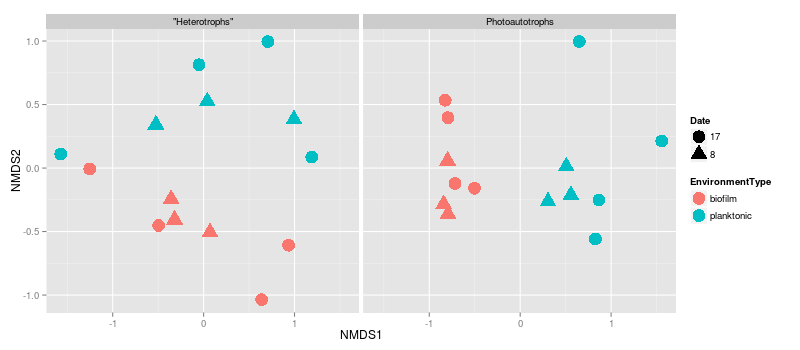

In [7]:
%%R -h 350 -w 800

p = ggplot(df.combined, aes(x = NMDS1, y = NMDS2))
p = p + geom_point(aes(color = EnvironmentType, shape = Date), size = 6)
p = p + facet_wrap(~libraryType)
#p = p + geom_text(aes(label = Experiment), vjust = 0)

print(p)

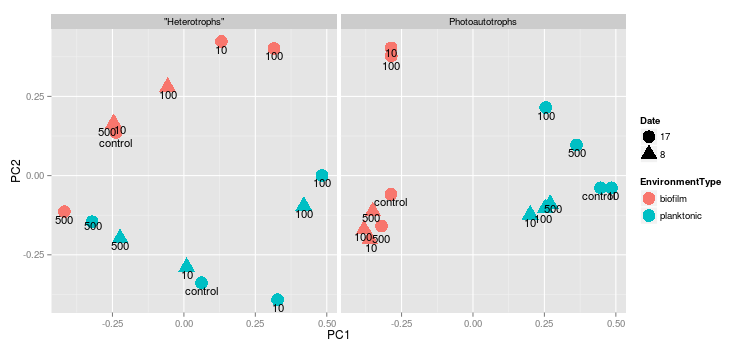

In [8]:
%%R -w 750 -h 350
mds.bact = ordinate(physeq.thresh.bact, "MDS", distance = "bray")
df.sites.bact = plot_ordination(physeq.thresh.bact, mds.bact, justDF = TRUE)
df.sites.bact$type = "sites"
df.sites.bact$libraryType = '"Heterotrophs"'

mds.euks = ordinate(physeq.thresh.euks, "MDS", distance = "bray")
df.sites.euks = plot_ordination(physeq.thresh.euks, mds.euks, justDF = TRUE)
df.sites.euks$type = "sites"
df.sites.euks$libraryType = "Photoautotrophs"


df.combined = ldply(list("Photoautotrophs" = df.sites.euks, '"Heterotrophs"' = df.sites.bact))
colnames(df.combined)[1] = "libraryType"

x.fact <- 100 / max(df.combined$Axis.1)
y.fact <- 100 / max(df.combined$Axis.2)

coords = FFieldPtRep(coords = cbind(df.combined$Axis.1 * x.fact,
                                    df.combined$Axis.2 * y.fact), 
                     rep.fact = 70)

df.combined$text.x = coords$x / x.fact
df.combined$text.y = coords$y / y.fact

p = ggplot(df.combined, aes(x = Axis.1, y = Axis.2))
p = p + geom_point(aes(color = EnvironmentType, shape = Date), size = 6)
p = p + geom_text(aes(x = text.x, 
                      y = text.y,
                      label = CarbonToPhosphorous), size = 4, vjust = 1.5, hjust = 0.5)
p = p + facet_wrap(~libraryType) + xlab("PC1") + ylab("PC2")

print(p)

In [9]:
%%R
ggsave("figs/bact_algae_MDS.pdf", p, w = 10, h = 5)

In [10]:
FileLink("figs/bact_algae_MDS.pdf")

/home/chuck/working/carbon_subsidies_biofilm_plankton/BvP_manuscript_figures/figures_and_stats/figs/bact_algae_MDS.pdf

In [11]:
%%R
ps = physeq.thresh.bact
mds = df.sites.bact
otus = t(otu_table(ps))
tax = tax_table(ps)

site.scores = mds[,c(1,2)]

if( setequal(row.names(mds), row.names(otus)) ){
    w = wascores(mds[,c(1,2)],otus,expand=TRUE)
} else {
    print("Indices don't match")
    print(setdiff(row.names(w), row.names(otus)))
}                                    
otu.scores = data.frame(w)

if( setequal(row.names(otu.scores), row.names(tax)) ){
    otu.scores.wtax = data.frame(otu.scores, tax)
} else {
    print("Indices not the same.")
    print(setdiff(row.names(otu.scores), row.names(tax)))
}

df.otus.bact = otu.scores.wtax
df.otus.bact$type = "OTUs"
df.otus.bact$libraryType = '"Heterotrophs"'

In [12]:
%%R
ps = physeq.thresh.euks
mds = df.sites.euks
otus = t(otu_table(ps))
tax = tax_table(ps)

site.scores = mds[,c(1,2)]

if( setequal(row.names(mds), row.names(otus)) ){
    w = vegan::wascores(mds[,c(1,2)],otus,expand=TRUE)
} else {
    print("Indices don't match")
    print(setdiff(row.names(w), row.names(otus)))
}                                    
otu.scores = data.frame(w)

if( setequal(row.names(otu.scores), row.names(tax)) ){
    otu.scores.wtax = data.frame(otu.scores, tax)
} else {
    print("Indices not the same.")
    print(setdiff(row.names(otu.scores), row.names(tax)))
}

df.otus.euks = otu.scores.wtax
df.otus.euks$type = "OTUs"
df.otus.euks$libraryType = "Photoautotrophs"

In [13]:
%%R
mds.bact$values

   Eigenvalues Relative_eig Broken_stick Cumul_eig Cumul_br_stick
1   1.14656858  0.258845354   0.24462567 0.2588454      0.2446257
2   0.92412194  0.208626572   0.16770260 0.4674719      0.4123283
3   0.69796574  0.157570331   0.12924106 0.6250423      0.5415693
4   0.38546848  0.087022031   0.10360003 0.7120643      0.6451694
5   0.25803631  0.058253384   0.08436926 0.7703177      0.7295386
6   0.23890649  0.053934701   0.06898465 0.8242524      0.7985233
7   0.19665440  0.044396016   0.05616414 0.8686484      0.8546874
8   0.16591488  0.037456369   0.04517512 0.9061048      0.8998625
9   0.13961011  0.031517895   0.03555974 0.9376227      0.9354223
10  0.10165711  0.022949757   0.02701273 0.9605724      0.9624350
11  0.09343421  0.021093384   0.01932042 0.9816658      0.9817554
12  0.04683113  0.010572433   0.01232742 0.9922382      0.9940828
13  0.03438117  0.007761773   0.00591716 1.0000000      1.0000000


In [14]:
%%R
mds.euks$values

    Eigenvalues  Relative_eig Rel_corr_eig Broken_stick Cum_corr_eig
1   1.554796821  0.4669988154  0.454280866  0.258600890    0.4542809
2   0.508320433  0.1526791390  0.150209204  0.175267557    0.6044901
3   0.420787813  0.1263878390  0.124775100  0.133600890    0.7292652
4   0.315163724  0.0946625848  0.094084210  0.105823112    0.8233494
5   0.224525982  0.0674386299  0.067747859  0.084989779    0.8910972
6   0.153223988  0.0460223612  0.047029842  0.068323112    0.9381271
7   0.064911355  0.0194967763  0.021369092  0.054434223    0.9594962
8   0.039284897  0.0117996127  0.013922885  0.042529461    0.9734191
9   0.028630719  0.0085995235  0.010827131  0.032112795    0.9842462
10  0.020385440  0.0061229714  0.008431323  0.022853535    0.9926775
11  0.005276167  0.0015847496  0.004041065  0.014520202    0.9967186
12  0.002661829  0.0007995071  0.003281424  0.006944444    1.0000000
13  0.000000000  0.0000000000  0.000000000  0.000000000    1.0000000
14 -0.008631341 -0.0025925098  0.0

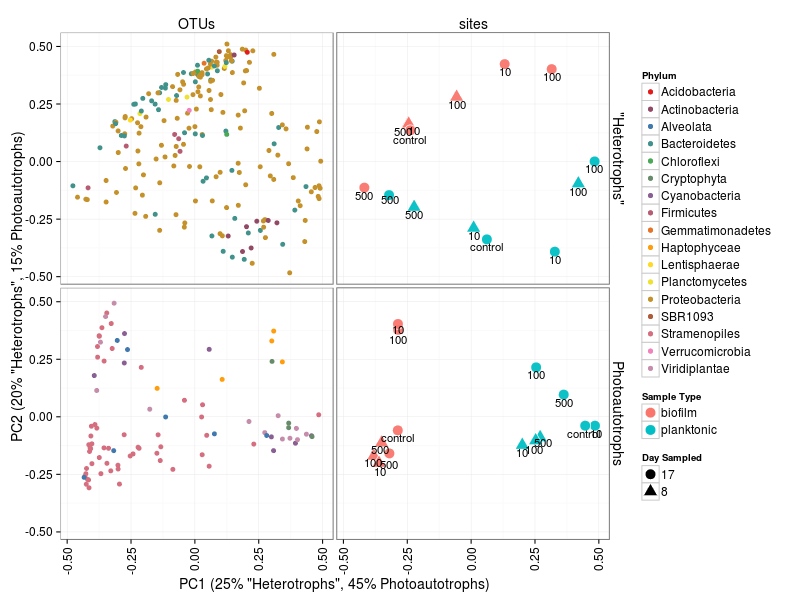

In [18]:
%%R -w 800 -h 600
d.sites.comb = rbind.fill(df.sites.bact, df.sites.euks)

x.fact <- 100 / max(d.sites.comb$Axis.1)
y.fact <- 100 / max(d.sites.comb$Axis.2)

coords = FFieldPtRep(coords = cbind(d.sites.comb$Axis.1 * x.fact,
                                    d.sites.comb$Axis.2 * y.fact), 
                     rep.fact = 70)

d.sites.comb$text.x = coords$x / x.fact
d.sites.comb$text.y = coords$y / y.fact

d = rbind.fill(df.otus.bact, df.otus.euks, d.sites.comb)

colourCount = length(unique(d$Rank2))
getPalette = colorRampPalette(brewer.pal(10, "Set1"))

p = ggplot(d, aes(x = Axis.1, y = Axis.2))
p = p + facet_grid(libraryType ~ type)
p = p + layer(data = df.otus.bact,  geom = c("point"), 
              mapping = aes(color = Rank2), size = 3, shape = 20)
p = p + layer(data = df.sites.bact,  geom = c("point"), 
              mapping = aes(fill = EnvironmentType, shape = Date), 
              alpha = 0.95, size = 5, color = "white")
p = p + layer(data = df.otus.euks,  geom = c("point"), 
              mapping = aes(color = Rank2), size = 3, shape = 20)
p = p + layer(data = df.sites.euks,  geom = c("point"), 
              mapping = aes(fill = EnvironmentType, shape = Date), 
              alpha = 0.95, size = 5, color = "white")

p = p + layer(data = d.sites.comb, geom = c("text"),
              mapping = aes(x = text.x, y = text.y, label = CarbonToPhosphorous), 
              size = 4, vjust = 1.5, hjust = 0.5)


p = p + scale_shape_manual(values = c(21, 24), guide=guide_legend(override.aes=aes(fill="black")))
p = p + scale_fill_manual(values = c("#f8766d", "#00bfc4"), guide=guide_legend(override.aes=aes(shape=21)))
p = p + scale_color_manual(values=getPalette(colourCount))
p = p + guides(color = guide_legend(title = "Phylum"))
p = p + xlab('PC1 (25% "Heterotrophs", 45% Photoautotrophs)') 
p = p + ylab('PC2 (20% "Heterotrophs", 15% Photoautotrophs)')

p = p + theme_bw()
p = p + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, size = 12), 
              axis.text.y = element_text(size = 12), 
              axis.title.x = element_text(size = 14), 
              axis.title.y = element_text(size = 14), 
              strip.text.x = element_text(size = 14), 
              strip.text.y = element_text(size = 14),
              legend.text = element_text(size = 12), 
              strip.background = element_blank())

p = p + labs(fill = "Sample Type", shape = "Day Sampled")

p

In [19]:
%%R
ggsave("figs/biplot_combined.pdf", p, w = 10, h = 7)

In [20]:
FileLink("figs/biplot_combined.pdf")

/home/chuck/working/carbon_subsidies_biofilm_plankton/BvP_manuscript_figures/figures_and_stats/figs/biplot_combined.pdf